In [1]:
import scipy.io as sio
from scipy.io import loadmat
import numpy as np
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import normalize
from scipy.optimize import minimize
from cvxopt import matrix, solvers
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the .mat files uploaded by the user
salinas_cube = sio.loadmat('Salinas_cube.mat')
salinas_gt = sio.loadmat('Salinas_gt.mat')
salinas_endmembers = sio.loadmat('Salinas_endmembers.mat')
classification_labels = sio.loadmat('classification_labels_Salinas.mat')

In [3]:
# Extract the actual data from the .mat files
salinas_cube_data = salinas_cube['salinas_cube']
salinas_gt_data = salinas_gt['salinas_gt']
salinas_endmembers_data = salinas_endmembers['salinas_endmembers']
classification_labels_operational_set = classification_labels['operational_set']
classification_labels_test_set = classification_labels['test_set']
classification_labels_training_set = classification_labels['training_set']

# Check the dimensions of the extracted data
(salinas_cube_data.shape, 
 salinas_gt_data.shape, 
 salinas_endmembers_data.shape,
 classification_labels_operational_set.shape, 
 classification_labels_test_set.shape, 
 classification_labels_training_set.shape)

((220, 120, 204), (220, 120), (204, 7), (26400, 1), (26400, 1), (26400, 1))

In [4]:
# Identify pixels with non-zero class labels
non_zero_labels_indices = np.where(salinas_gt_data > 0)

# Extract the spectral data for pixels with non-zero class labels
non_zero_labels_spectral_data = salinas_cube_data[non_zero_labels_indices[0], non_zero_labels_indices[1], :]

# Reshape the endmember data to match the spectral data (for subsequent operations)
endmembers = salinas_endmembers_data.T  # Transpose to shape (7, 204) to match (pixels, bands)

non_zero_labels_spectral_data.shape, endmembers.shape

((16929, 204), (7, 204))

### Project Part 1

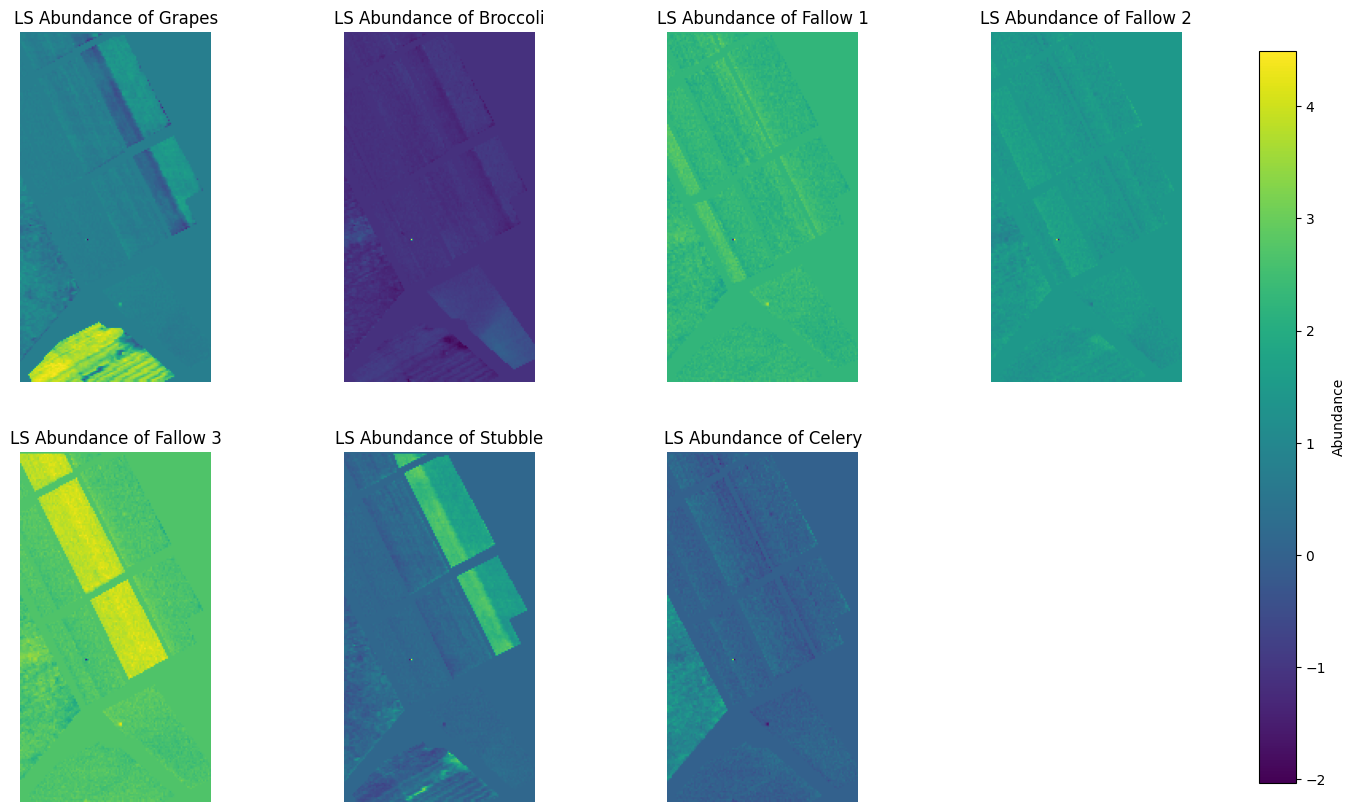

Average Reconstruction Error: 35058.88066277264


In [5]:
endmember_names = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']

# Function to perform default least squares for one pixel
def default_least_squares(endmembers, pixel_spectrum):
    # Solve the least squares problem (no constraints)
    b, residuals, rank, s = np.linalg.lstsq(endmembers, pixel_spectrum, rcond=None)
    return b

# Load the data
salinas_cube = loadmat('Salinas_cube.mat')['salinas_cube']
salinas_gt = loadmat('Salinas_gt.mat')['salinas_gt']
salinas_endmembers = loadmat('Salinas_endmembers.mat')['salinas_endmembers']

# Extract only pixels with nonzero labels and perform unmixing
nonzero_indices = np.where(salinas_gt > 0)

# Re-initialize the abundance maps and reconstruction errors for default least squares
abundance_maps_ls = np.zeros((salinas_gt.shape[0], salinas_gt.shape[1], salinas_endmembers.shape[1]))
reconstruction_errors_ls = []

# Perform unmixing for each pixel with a nonzero label using default least squares
for i, j in zip(nonzero_indices[0], nonzero_indices[1]):
    pixel_spectrum = salinas_cube[i, j, :]
    abundances_ls = default_least_squares(salinas_endmembers, pixel_spectrum)
    abundance_maps_ls[i, j, :] = abundances_ls
    reconstruction_error_ls = np.linalg.norm(pixel_spectrum - salinas_endmembers @ abundances_ls)**2
    reconstruction_errors_ls.append(reconstruction_error_ls)

# Compute the average reconstruction error for the default least squares method
average_reconstruction_error_ls = np.mean(reconstruction_errors_ls)

# Visualize abundance maps for each endmember using default least squares results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < 7:
        im = ax.imshow(abundance_maps_ls[:, :, i], cmap='viridis')
        ax.set_title(f"LS Abundance of {endmember_names[i]}")
        ax.axis('off')
    else:
        ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label='Abundance')
plt.show() 
print(f"Average Reconstruction Error: {average_reconstruction_error_ls}")

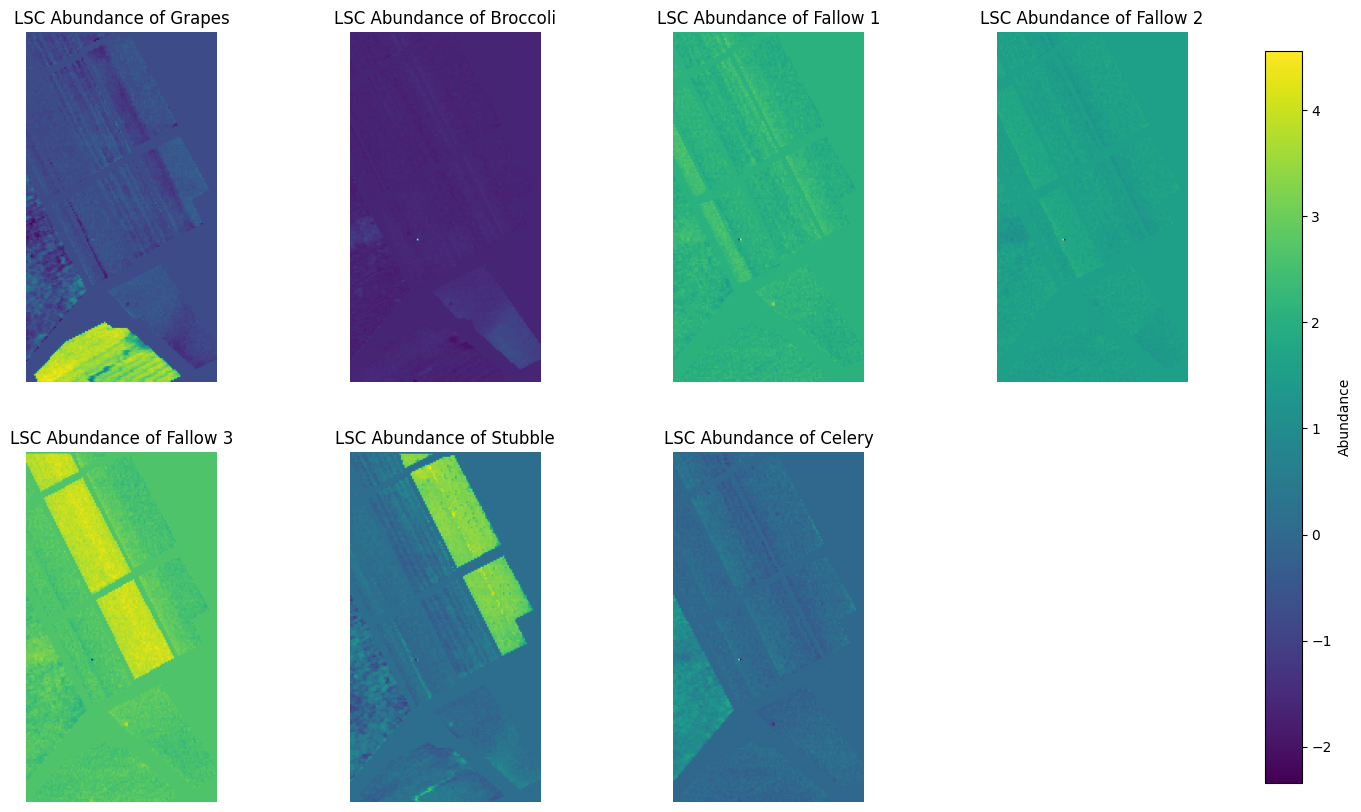

Average Reconstruction Error: 43082.57630024289


In [6]:
from scipy.io import loadmat
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Load the data
salinas_cube = loadmat('Salinas_cube.mat')['salinas_cube']
salinas_gt = loadmat('Salinas_gt.mat')['salinas_gt']
salinas_endmembers = loadmat('Salinas_endmembers.mat')['salinas_endmembers']

# Function to perform constrained least squares for one pixel
def constrained_least_squares(endmembers, pixel_spectrum):
    fun = lambda b: np.linalg.norm(pixel_spectrum - endmembers @ b)**2
    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1})
    x0 = np.full(endmembers.shape[1], 1 / endmembers.shape[1])
    res = minimize(fun, x0, bounds=None, constraints=cons)
    return res.x

# Extract only pixels with nonzero labels and perform unmixing
nonzero_indices = np.where(salinas_gt > 0)
abundance_maps = np.zeros((salinas_gt.shape[0], salinas_gt.shape[1], salinas_endmembers.shape[1]))
reconstruction_errors = []

for i, j in zip(nonzero_indices[0], nonzero_indices[1]):
    pixel_spectrum = salinas_cube[i, j, :]
    abundances = constrained_least_squares(salinas_endmembers, pixel_spectrum)
    abundance_maps[i, j, :] = abundances
    reconstruction_error = np.linalg.norm(pixel_spectrum - salinas_endmembers @ abundances)**2
    reconstruction_errors.append(reconstruction_error)

average_reconstruction_error = np.mean(reconstruction_errors)

# Visualize abundance maps
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
endmember_names = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']

for i, ax in enumerate(axes.flat):
    if i < 7:
        im = ax.imshow(abundance_maps[:, :, i], cmap='viridis')
        ax.set_title(f"LSC Abundance of {endmember_names[i]}")
        ax.axis('off')
    else:
        ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label='Abundance')
plt.show()

print(f"Average Reconstruction Error: {average_reconstruction_error}")


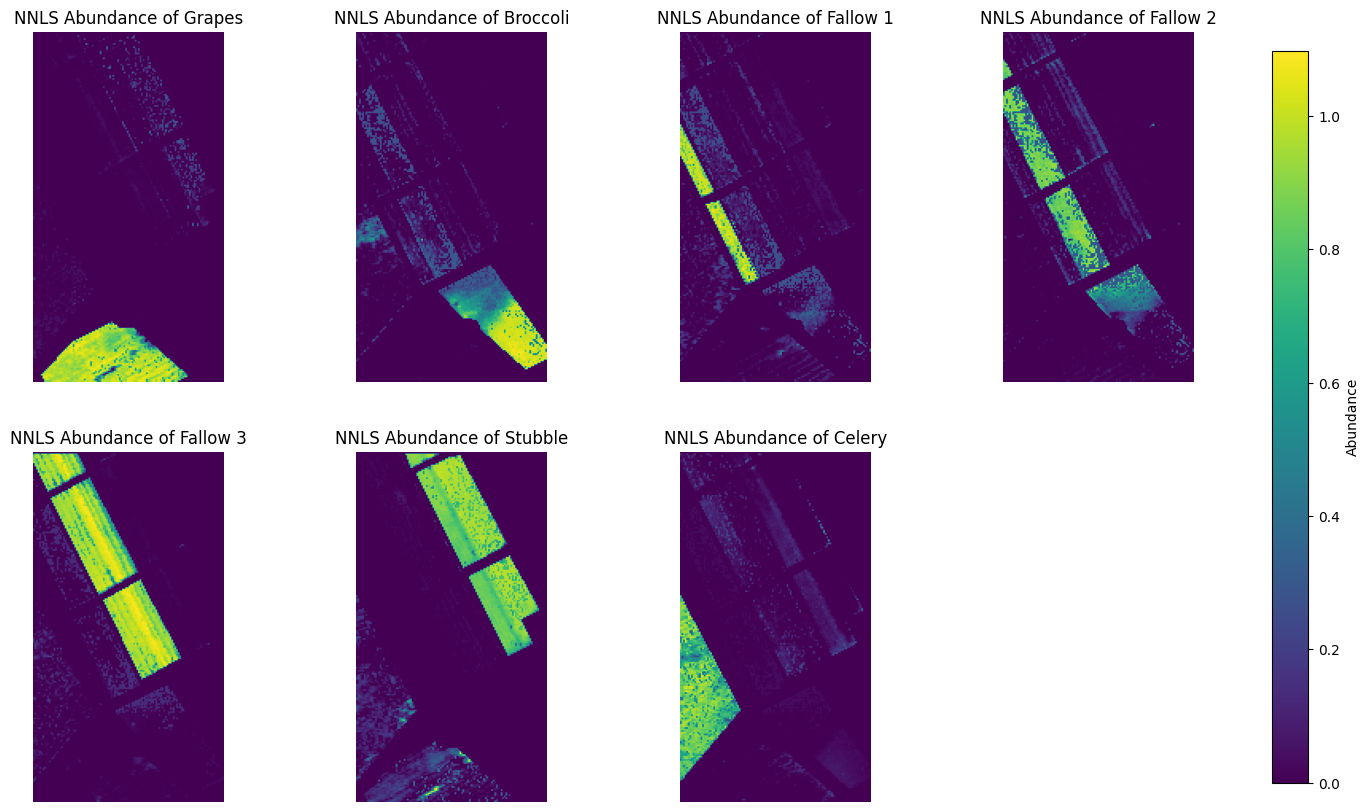

Average Reconstruction Error: 260766.12535419955


In [7]:
# Function to perform least squares with non-negativity constraints for one pixel
def least_squares_nonnegativity(endmembers, pixel_spectrum):
    # Objective function: ||y - Xb||^2
    fun = lambda b: np.linalg.norm(pixel_spectrum - endmembers @ b)**2
    
    # Constraints: 0 <= b_i for each abundance (non-negativity)
    bnds = [(0, None) for _ in range(endmembers.shape[1])]
    
    # Initial guess
    x0 = np.full(endmembers.shape[1], 1 / endmembers.shape[1])
    
    # Solve the optimization problem with non-negativity constraints
    res = minimize(fun, x0, bounds=bnds)
    
    return res.x

# Re-initialize the abundance maps and reconstruction errors for non-negativity constrained least squares
abundance_maps_nn = np.zeros((salinas_gt.shape[0], salinas_gt.shape[1], salinas_endmembers.shape[1]))
reconstruction_errors_nn = []

# Perform unmixing for each pixel with a nonzero label using non-negativity constrained least squares
for i, j in zip(nonzero_indices[0], nonzero_indices[1]):
    pixel_spectrum = salinas_cube[i, j, :]
    abundances_nn = least_squares_nonnegativity(salinas_endmembers, pixel_spectrum)
    abundance_maps_nn[i, j, :] = abundances_nn
    reconstruction_error_nn = np.linalg.norm(pixel_spectrum - salinas_endmembers @ abundances_nn)**2
    reconstruction_errors_nn.append(reconstruction_error_nn)

# Compute the average reconstruction error for the non-negativity constrained least squares method
average_reconstruction_error_nn = np.mean(reconstruction_errors_nn)

# Visualize abundance maps for each endmember using non-negativity constrained least squares results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < 7:
        im = ax.imshow(abundance_maps_nn[:, :, i], cmap='viridis')
        ax.set_title(f"NNLS Abundance of {endmember_names[i]}")
        ax.axis('off')
    else:
        ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label='Abundance')
plt.show()
print(f"Average Reconstruction Error: {average_reconstruction_error_nn}")

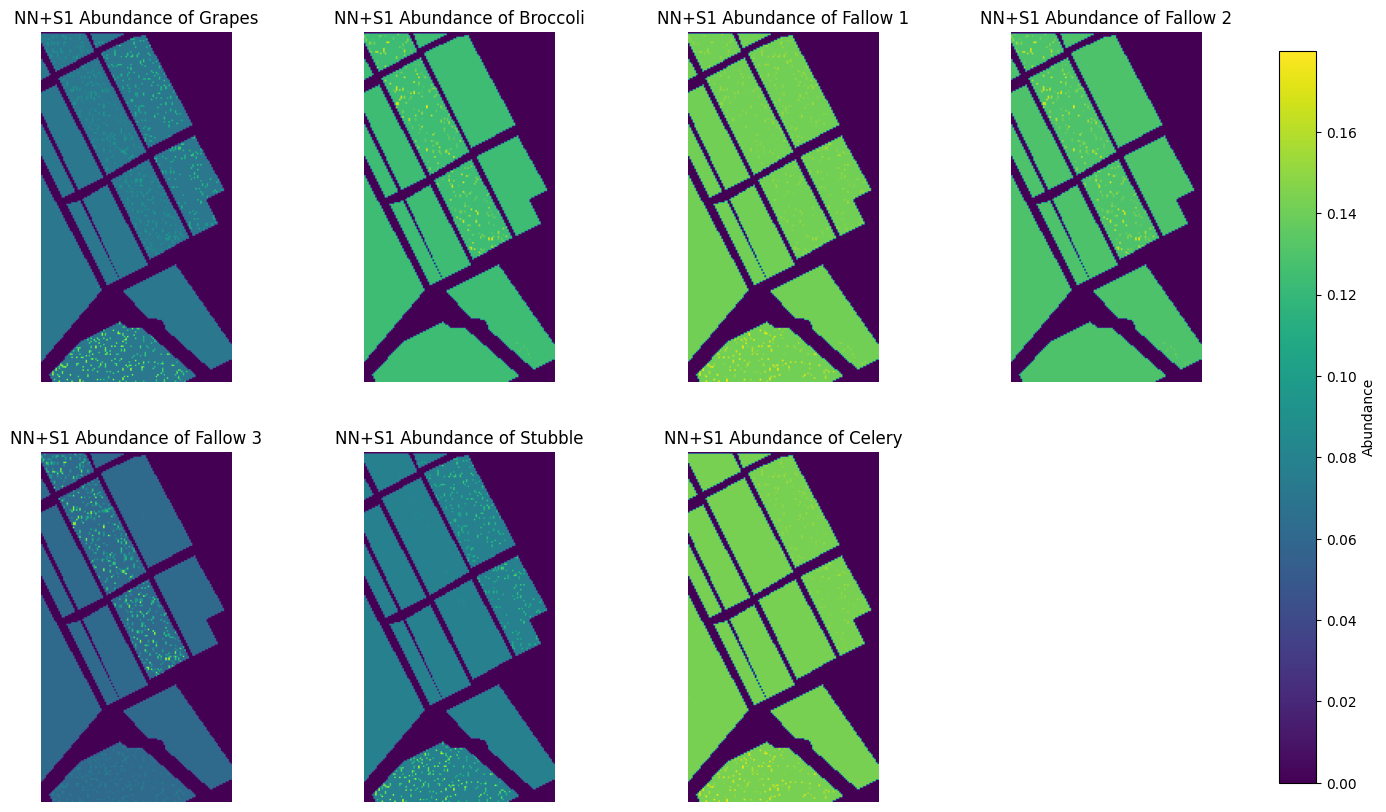

Average Reconstruction Error: 83695018.44670562


In [8]:
# Function to perform least squares with non-negativity and sum-to-one constraints for one pixel
def least_squares_nonnegativity_sumtoone(endmembers, pixel_spectrum):
    # Objective function: ||y - Xb||^2
    fun = lambda b: np.linalg.norm(pixel_spectrum - endmembers @ b)**2
    
    # Constraints: sum(b) = 1 (sum-to-one constraint)
    cons = [{'type': 'eq', 'fun': lambda b: np.sum(b) - 1}]
    
    # Bound constraints: 0 <= b_i for each abundance (non-negativity)
    bnds = [(0, None) for _ in range(endmembers.shape[1])]
    
    # Initial guess
    x0 = np.full(endmembers.shape[1], 1 / endmembers.shape[1])
    
    # Solve the optimization problem with both constraints
    res = minimize(fun, x0, bounds=bnds, constraints=cons)
    
    return res.x

# Re-initialize the abundance maps and reconstruction errors for least squares with both constraints
abundance_maps_nns1 = np.zeros((salinas_gt.shape[0], salinas_gt.shape[1], salinas_endmembers.shape[1]))
reconstruction_errors_nns1 = []

# Perform unmixing for each pixel with a nonzero label using least squares with both constraints
for i, j in zip(nonzero_indices[0], nonzero_indices[1]):
    pixel_spectrum = salinas_cube[i, j, :]
    abundances_nns1 = least_squares_nonnegativity_sumtoone(salinas_endmembers, pixel_spectrum)
    abundance_maps_nns1[i, j, :] = abundances_nns1
    reconstruction_error_nns1 = np.linalg.norm(pixel_spectrum - salinas_endmembers @ abundances_nns1)**2
    reconstruction_errors_nns1.append(reconstruction_error_nns1)

# Compute the average reconstruction error for the least squares method with both constraints
average_reconstruction_error_nns1 = np.mean(reconstruction_errors_nns1)

# Visualize abundance maps for each endmember using least squares with both constraints results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    if i < 7:
        im = ax.imshow(abundance_maps_nns1[:, :, i], cmap='viridis')
        ax.set_title(f"NN+S1 Abundance of {endmember_names[i]}")
        ax.axis('off')
    else:
        ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label='Abundance')
plt.show()
print(f"Average Reconstruction Error: {average_reconstruction_error_nns1}")

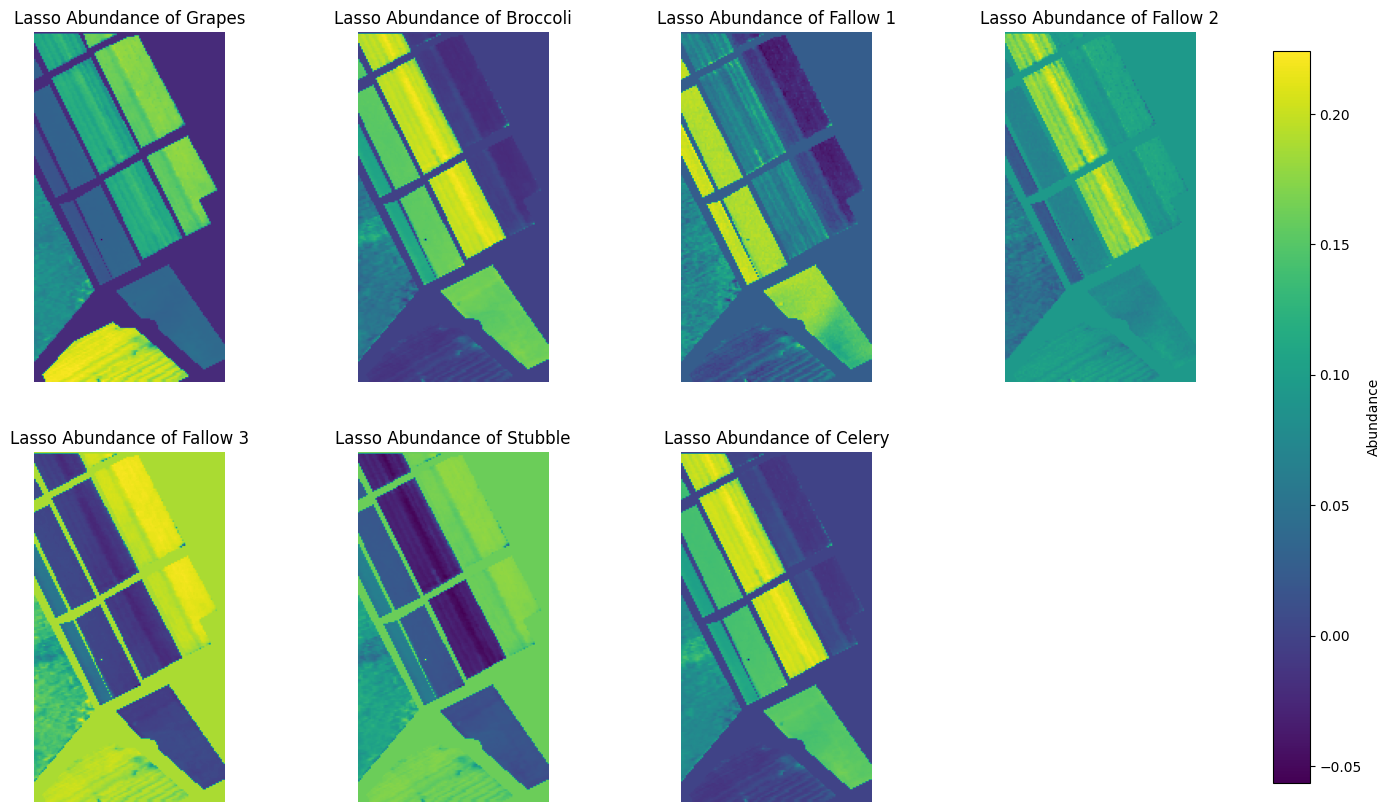

Average Reconstruction Error: 2269.477004507375


In [9]:
# Define endmember names based on the provided materials
endmember_names = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']

# Load the provided MAT files
salinas_cube = loadmat('Salinas_cube.mat')
salinas_endmembers = loadmat('Salinas_endmembers.mat')
salinas_gt = loadmat('Salinas_gt.mat')

# Extract the necessary data from the MAT files
salinas_cube_data = salinas_cube['salinas_cube']
salinas_endmembers_data = salinas_endmembers['salinas_endmembers']
salinas_gt_data = salinas_gt['salinas_gt']

# Reshape the hyperspectral image data
num_pixels = salinas_cube_data.shape[0] * salinas_cube_data.shape[1]
num_bands = salinas_cube_data.shape[2]
pixels_data = salinas_cube_data.reshape((num_pixels, num_bands))

# Reshape the ground truth to match the reshaped hyperspectral data
gt_labels_reshaped = salinas_gt_data.flatten()

# Filter out pixels with zero labels (background)
nonzero_indices = np.where(gt_labels_reshaped > 0)[0]
nonzero_pixels_data = pixels_data[nonzero_indices, :]

# Initialize LASSO model with adjusted parameters
lasso_model_adjusted = Lasso(alpha=0.01, max_iter=50000, tol=0.4)

# Prepare to store abundance estimates
abundance_estimates_adjusted = np.zeros((nonzero_pixels_data.shape[0], salinas_endmembers_data.shape[1]))

# Initialize a list to store reconstruction errors
reconstruction_errors = []

# Perform LASSO regression with adjusted parameters and calculate reconstruction error
for i, pixel in enumerate(nonzero_pixels_data):
    lasso_model_adjusted.fit(salinas_endmembers_data, pixel)
    abundance_estimates_adjusted[i, :] = lasso_model_adjusted.coef_
    reconstructed_pixel = np.dot(salinas_endmembers_data, lasso_model_adjusted.coef_)
    reconstruction_errors.append(np.linalg.norm(pixel - reconstructed_pixel))

# Compute the average reconstruction error
average_reconstruction_error = np.mean(reconstruction_errors)

# Prepare abundance maps for visualization
abundance_maps = np.zeros((salinas_cube_data.shape[0], salinas_cube_data.shape[1], salinas_endmembers_data.shape[1]))

# Fill in the abundance maps with the estimated abundances
for i, index in enumerate(nonzero_indices):
    row = index // salinas_cube_data.shape[1]
    col = index % salinas_cube_data.shape[1]
    abundance_maps[row, col, :] = abundance_estimates_adjusted[i, :]

# Plot the abundance maps for each endmember with a shared colorbar
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the number of subplots if necessary
for i, ax in enumerate(axes.flat):
    if i < 7:  # Adjust the range to match the number of endmembers
        im = ax.imshow(abundance_maps[:, :, i], cmap='viridis')
        ax.set_title(f"Lasso Abundance of {endmember_names[i]}")
        ax.axis('off')
    else:
        ax.axis('off')

# Add a colorbar to the last subplot placeholder
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label='Abundance')
plt.show()

# Print the average reconstruction error
print(f"Average Reconstruction Error: {average_reconstruction_error}")

### Project Part 2

In [10]:
# Load the HSI data and ground truth labels
salinas_cube = sio.loadmat('Salinas_cube.mat')['salinas_cube']
salinas_gt = sio.loadmat('Salinas_gt.mat')['salinas_gt']

# Verify the shapes of the loaded arrays again to ensure correct data handling
salinas_cube.shape, salinas_gt.shape

# Extract features (spectral bands) and labels for non-zero labeled pixels
features = salinas_cube.reshape(-1, salinas_cube.shape[2])[salinas_gt.flatten() > 0]
labels = salinas_gt.flatten()[salinas_gt.flatten() > 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=42)

# Check the size of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11850, 204), (5079, 204), (11850,), (5079,))

In [11]:
# Naïve Bayes classifier with 10-fold cross-validation
gnb_cv_scores = cross_val_score(GaussianNB(), X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Calculate mean and standard deviation of cross-validation scores
gnb_cv_mean = np.mean(gnb_cv_scores)
gnb_cv_std = np.std(gnb_cv_scores)

gnb_cv_mean, gnb_cv_std

(0.9837130801687763, 0.0025330516489119903)

In [12]:
# Train the Naïve Bayes classifier on the whole training set
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict on the test set
y_pred_gnb = gnb.predict(X_test)

# Compute the confusion matrix and the success rate (accuracy)
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
success_rate_gnb = accuracy_score(y_test, y_pred_gnb)

conf_matrix_gnb, success_rate_gnb

(array([[ 676,    0,    0,    0,    0,    0,    3],
        [   6,  650,    0,    0,    0,    0,    0],
        [   0,    0,  539,    1,   47,    0,    0],
        [   0,    0,    0,  245,    4,    0,    0],
        [   0,    0,   15,    8,  625,    0,    0],
        [   6,    0,    2,    0,    0, 1178,    0],
        [   8,    0,    0,    0,    0,    0, 1066]], dtype=int64),
 0.9803110848592242)

In [13]:
def minimum_euclidean_distance_classifier(X_train, y_train, X_test):
    # Calculate the mean vector for each class
    class_means = np.array([X_train[y_train == i].mean(axis=0) for i in np.unique(y_train)])
    
    # Predict the class for each sample in the test set based on the minimum Euclidean distance
    distances = np.sqrt(((X_test[:, np.newaxis, :] - class_means) ** 2).sum(axis=2))
    y_pred = np.argmin(distances, axis=1) + 1  # Class labels start from 1
    
    return y_pred

# Predict the classes for the test set using the minimum Euclidean distance classifier
y_pred_med = minimum_euclidean_distance_classifier(X_train, y_train, X_test)

# Compute the confusion matrix and success rate for the minimum Euclidean distance classifier
conf_matrix_med = confusion_matrix(y_test, y_pred_med)
success_rate_med = accuracy_score(y_test, y_pred_med)

conf_matrix_med, success_rate_med

(array([[ 661,    0,    9,    0,    0,    0,    9],
        [   2,  609,    0,    0,    0,    0,   45],
        [   0,    0,  472,    1,  114,    0,    0],
        [   0,    0,    0,  245,    4,    0,    0],
        [   0,    0,   23,    8,  617,    0,    0],
        [   1,    0,    7,    0,    0, 1176,    2],
        [   6,    1,    1,    0,    0,    0, 1066]], dtype=int64),
 0.9541248277219925)

In [14]:
# k-Nearest Neighbors (k-NN) Classifier with 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

# Calculate mean and standard deviation of cross-validation scores for k-NN
knn_cv_mean = np.mean(knn_cv_scores)
knn_cv_std = np.std(knn_cv_scores)

knn_cv_mean, knn_cv_std

(0.9964556962025316, 0.0015001172012347008)

In [15]:
# Train the k-NN classifier on the whole training set and evaluate on the test set
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Compute the confusion matrix and success rate for the k-NN classifier
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
success_rate_knn = accuracy_score(y_test, y_pred_knn)

conf_matrix_knn, success_rate_knn

(array([[ 678,    0,    0,    0,    0,    0,    1],
        [   0,  655,    0,    0,    0,    0,    1],
        [   0,    0,  583,    0,    4,    0,    0],
        [   0,    0,    0,  245,    4,    0,    0],
        [   0,    0,    5,    6,  636,    1,    0],
        [   0,    0,    0,    0,    0, 1186,    0],
        [   2,    0,    0,    0,    0,    0, 1072]], dtype=int64),
 0.9952746603662138)

In [16]:
class CustomBayesianClassifier:
    def __init__(self):
        self.class_priors = None
        self.class_features_mean = None
        self.class_features_var = None
        self.classes = None
    
    def fit(self, X, y):
        # Identify unique classes and their frequencies to compute prior probabilities
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.class_priors = class_counts / class_counts.sum()
        
        # Calculate mean and variance for each feature in each class
        self.class_features_mean = np.array([X[y == c].mean(axis=0) for c in self.classes])
        self.class_features_var = np.array([X[y == c].var(axis=0) for c in self.classes])
        
    def predict(self, X):
        # Compute posterior probabilities for each class
        posteriors = []
        for i, c in enumerate(self.classes):
            prior = np.log(self.class_priors[i])
            conditional = np.sum(np.log(self._pdf(i, X)), axis=1)
            posterior = prior + conditional
            posteriors.append(posterior)
        # Classify based on the highest posterior probability
        return self.classes[np.argmax(posteriors, axis=0)]
    
    def _pdf(self, class_idx, X):
        # Gaussian PDF function for likelihood computation
        mean = self.class_features_mean[class_idx]
        var = self.class_features_var[class_idx]
        numerator = np.exp(-(X - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

# Instantiate the classifier
custom_bayes = CustomBayesianClassifier()

# Fit the classifier
custom_bayes.fit(X_train, y_train)

# Predict on the test set
y_pred_bayes = custom_bayes.predict(X_test)

# Compute the confusion matrix and success rate
conf_matrix_bayes = confusion_matrix(y_test, y_pred_bayes)
success_rate_bayes = accuracy_score(y_test, y_pred_bayes)

conf_matrix_bayes, success_rate_bayes

C:\Users\THAN\AppData\Local\Temp\ipykernel_12008\3060408143.py:22: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self._pdf(i, X)), axis=1)


(array([[ 676,    0,    0,    0,    0,    0,    3],
        [   6,  650,    0,    0,    0,    0,    0],
        [   0,    0,  539,    1,   47,    0,    0],
        [   0,    0,    0,  245,    4,    0,    0],
        [   1,    0,   14,    8,  625,    0,    0],
        [   6,    0,    2,    0,    0, 1178,    0],
        [   8,    0,    0,    0,    0,    0, 1066]], dtype=int64),
 0.9803110848592242)